In [76]:
import torch
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets
from torchvision import transforms as T
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(613)

In [77]:
tforms = T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)])

train_data = datasets.MNIST(download=True, root='MNIST_data', train=True, transform=tforms)
test_data = datasets.MNIST(download=True, root='MNIST_data', train=False, transform=tforms)

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [79]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

# FOR NOW
valid_iter = test_iter

In [80]:
class Network(nn.Module):

    def __init__(self, dim):
        super().__init__()

        middle_lays = [512, 256, 144]
        self.input = nn.Linear(dim, middle_lays[0])
        self.l1 = nn.Linear(middle_lays[0], middle_lays[1])
        self.l2 = nn.Linear(middle_lays[1], middle_lays[2])
        self.l3 = nn.Linear(middle_lays[2], middle_lays[1])
        self.l4 = nn.Linear(middle_lays[1], middle_lays[0])
        self.output = nn.Linear(middle_lays[0], dim)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.output(x)

        return x

    def encode(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))

        return x

    def decode(self, x):
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.output(x)

        return x

In [81]:
model = Network(dim=28**2)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0003)

In [82]:
epochs = 8
train_losses = []
valid_losses = []

In [83]:
for e in range(epochs):
    model.train()

    for images, _ in train_iter:
        images = images.view(images.shape[0], -1)
        images = images.to(device)

        model_out = model(images)
        loss = criterion(model_out, images)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        
        for images, _ in test_iter:
            images = images.view(images.shape[0], -1)
            images = images.to(device)

            model_out = model(images)
            loss = criterion(model_out, images)
            valid_losses.append(loss.item())
            

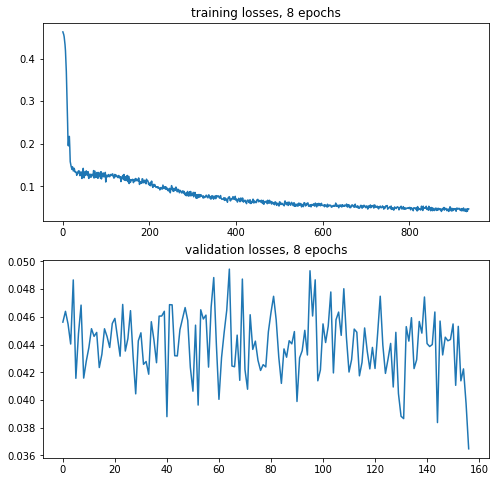

In [84]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(8,8)

ax[0].plot(train_losses)
ax[0].set_title(f'training losses, {epochs} epochs')

ax[1].plot(valid_losses)
ax[1].set_title(f'validation losses, {epochs} epochs')

plt.show()

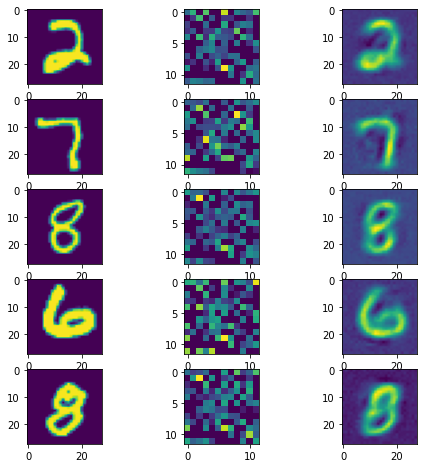

In [85]:
model.eval()
images, _ = next(iter(test_loader))

first_images = images[:5]
second_images = images[5:10]

fig, ax = plt.subplots(len(first_images), 3)
fig.set_size_inches(8,8)

for i, image in enumerate(first_images):
    image = image.view(28, 28)
    ax[i][0].imshow(image)

    image = image.view(-1)
    encoded = model.encode(image)
    
    encoded = encoded.view(12, 12)
    encoded = encoded.detach()
    ax[i][1].imshow(encoded)
    
    encoded = encoded.view(-1)
    model_out = model.decode(encoded)
    model_out = model_out.view(28, 28)
    model_out = model_out.detach()
    ax[i][2].imshow(model_out)

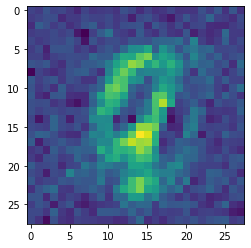

In [86]:
import numpy as np

random_img = torch.Tensor([np.random.uniform(0, 1) for i in range(144)])
decoded_img = model.decode(random_img)
decoded_img = decoded_img.view(28, 28).detach()

plt.imshow(decoded_img)